# Imports

In [1]:
import tensorflow as tf
from tensorflow_probability import edward2 as ed
import numpy as np
import matplotlib.pyplot as plt
import inferpy as inf
from inferpy.data import mnist
import pandas as pd
import sys

import warnings
warnings.filterwarnings("ignore")

# Global configuration
num_epochs = 3000
tf.reset_default_graph()
tf.set_random_seed(1234)
verbose = True
learning_rate = 0.01

/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hom

# Data 


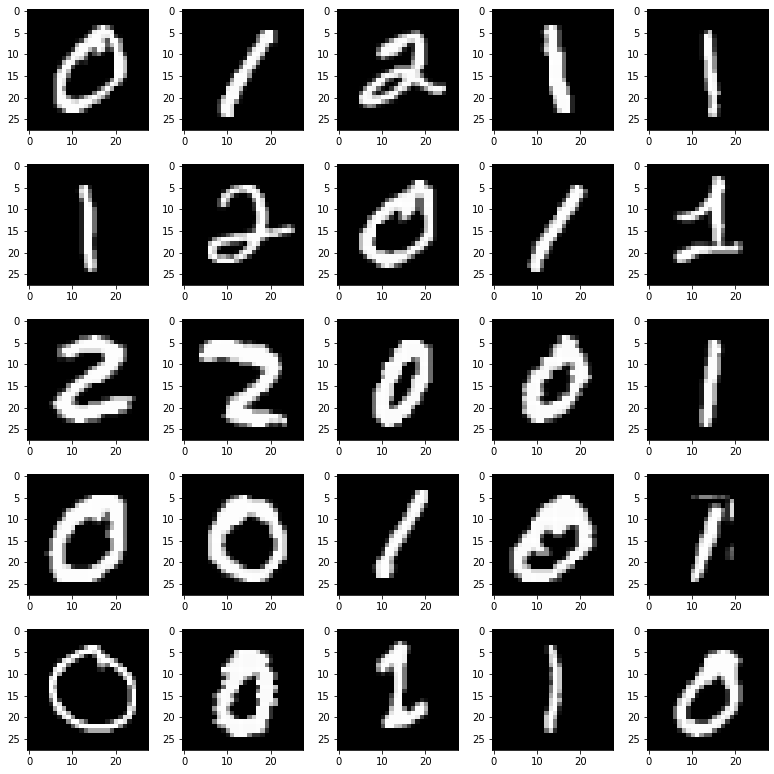

In [2]:
# number of observations (dataset size)
N = 1000
# digits considered
DIG = [0,1,2]

# load the data
(x_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)

# plot the digits
mnist.plot_digits(x_train, grid=[5,5])

# Model definition
The input parameters are: $k$ is the latent dimension, $d$ is the data-dimension and $N$ the number of samples or data instances. 

In [3]:
# Model constants
k, d0, d1 = 2, 100, np.shape(x_train)[-1]

# initial values
loc_init = 0.001
scale_init = 1

@inf.probmodel
def nlpca(k, d0, d1, decoder):
    decoder_call = decoder(k, d0, d1)
    with inf.datamodel():
        # Define local latent variables
        z = inf.Normal(loc=tf.ones([k]), scale=1, name="z")

        output = decoder_call(z)

        # Define the observed variables
        x = inf.Normal(loc=output, scale=1., name="x")


def decoder(k, d0, d1):

    beta0 = inf.Normal(tf.ones([k, d0]) * loc_init, scale_init, name="beta0")
    alpha0 = inf.Normal(tf.ones([d0]) * loc_init, scale_init, name="alpha0")
    
    ######

    beta1 = inf.Normal(tf.ones([d0, d1]) * loc_init, scale_init, name="beta1")
    alpha1 = inf.Normal(tf.ones([d1]) * loc_init, scale_init, name="alpha1")

    def call(z):
        h0 = tf.nn.relu(z @ beta0 + alpha0, name="h0")
        return h0 @ beta1 + alpha1

    return call

# Inference

Variational inference is a deterministic technique that finds a tractable approximation to an intractable (posterior) distribution. 
We will use $q$ to denote the approximation, and use $p$ to signify the true distribution (like $p(\boldsymbol{\beta, \alpha},\boldsymbol{z}|\boldsymbol{x})$ in the example above).
More specifically, ${\cal Q}$ will denote a set of possible approximations $q$.

In practice, we define a generative model for sampling from $q(\boldsymbol{\beta, \alpha},\boldsymbol{z} | \boldsymbol{\lambda}, \boldsymbol{\phi})$, where $\boldsymbol{\lambda}, \boldsymbol{\phi}$ are the variational parameters to optimise.





In [4]:
@inf.probmodel
def Q(k, d0, d1):

    with inf.datamodel():
        qz_loc = inf.Parameter(tf.ones([k]), name="qz_loc")
        qz_scale = tf.math.softplus(inf.Parameter(tf.ones([k]), name="qz_scale"))
        qz = inf.Normal(loc=qz_loc, scale=qz_scale, name="z")

    ###

    qbeta0_loc = inf.Parameter(tf.ones([k, d0]) * loc_init, name="qbeta0_loc")
    qbeta0_scale = tf.math.softplus(inf.Parameter(tf.ones([k, d0]) * scale_init, name="qbeta0_scale"))
    qbeta0 = inf.Normal(qbeta0_loc, qbeta0_scale, name="beta0")

    qalpha0_loc = inf.Parameter(tf.ones([d0]) * loc_init, name="qalpha0_loc")
    qalpha0_scale = tf.math.softplus(inf.Parameter(tf.ones([d0]) * scale_init, name="qalpha0_scale"))
    qalpha0 = inf.Normal(qalpha0_loc, qalpha0_scale, name="alpha0")

    ###

    qbeta1_loc = inf.Parameter(tf.ones([d0, d1]) * loc_init, name="qbeta1_loc")
    qbeta1_scale = tf.math.softplus(inf.Parameter(tf.ones([d0, d1]) * scale_init, name="qbeta1_scale"))
    qbeta1 = inf.Normal(qbeta1_loc, qbeta1_scale, name="beta1")

    qalpha1_loc = inf.Parameter(tf.ones([d1]) * loc_init, name="qalpha1_loc")
    qalpha1_scale = tf.math.softplus(inf.Parameter(tf.ones([d1]) * scale_init, name="qalpha1_scale"))
    qalpha1 = inf.Normal(qalpha1_loc, qalpha1_scale, name="alpha1")

<function Q at 0x7fd478259d90>


In [5]:
# create an instance of the P model and the Q model
m = nlpca(k, d0, d1, decoder)
q = Q(k,d0,d1)

# load the data
(x_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)

optimizer = tf.train.AdamOptimizer(learning_rate)
VI = inf.inference.VI(q, optimizer=optimizer, epochs=4000)

Finally, the ELBO function is maximized.

In [6]:
m.fit({"x": x_train}, VI)        


 0 epochs	 3261792512.0....................
 200 epochs	 1968752000.0....................
 400 epochs	 1762021504.0....................
 600 epochs	 1639211776.0....................
 800 epochs	 1401921792.0....................
 1000 epochs	 1290258048.0....................
 1200 epochs	 1205727872.0....................
 1400 epochs	 1174681344.0....................
 1600 epochs	 1146108160.0....................
 1800 epochs	 1097449984.0....................
 2000 epochs	 1054958848.0....................
 2200 epochs	 1007006528.0....................
 2400 epochs	 976774976.0....................
 2600 epochs	 958687232.0....................
 2800 epochs	 943289600.0....................
 3000 epochs	 928455872.0....................
 3200 epochs	 914996736.0....................
 3400 epochs	 901899264.0....................
 3600 epochs	 888369344.0....................
 3800 epochs	 875715136.0....................

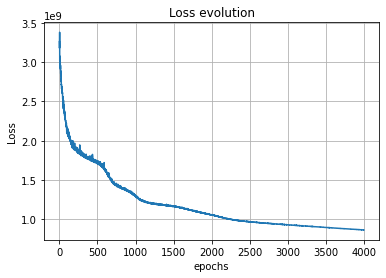

In [9]:
L = VI.losses
plt.plot(range(len(L)), L)

plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss evolution')
plt.grid(True)
plt.show()

After the inference, we can plot the hidden representation:

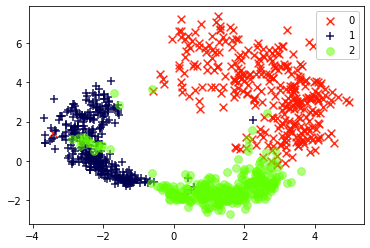

In [7]:
post = {"z": m.posterior("z", data={"x": x_train}).sample()}

markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()

for c in range(0, len(DIG)):
    col = colors[c]
    plt.scatter(post["z"][y_train == DIG[c], 0], post["z"][y_train == DIG[c], 1], color=col,
                label=DIG[c], marker=markers[c], alpha=transp[c], s=60)
    plt.legend(loc='upper right',framealpha=1)

## Test

For testing our model, we will generate samples of $\boldsymbol{x}$ given the infered posterior distributions.

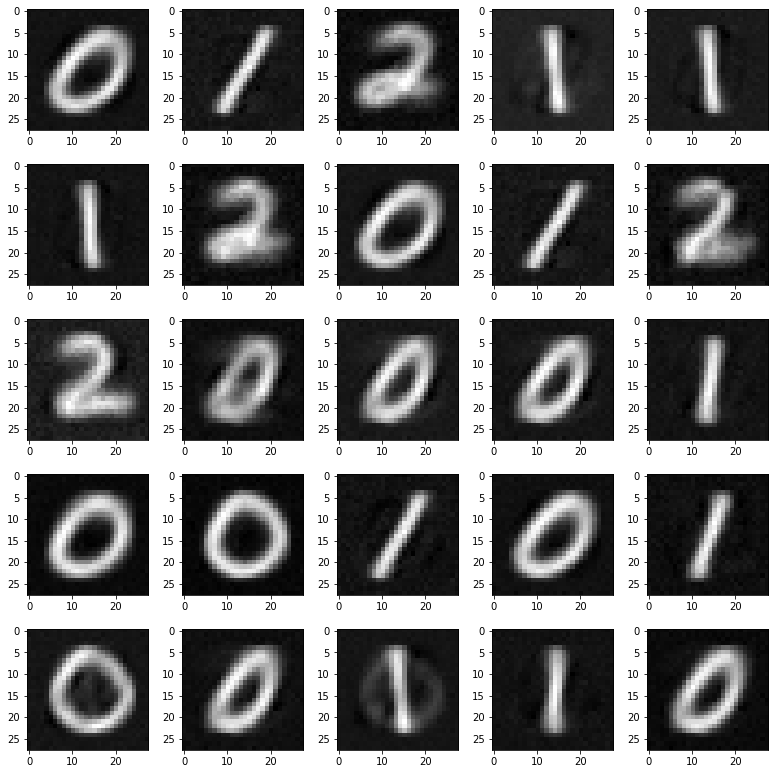

In [8]:
x_gen = m.posterior_predictive('x', data=post).sample()

# plot the digits
mnist.plot_digits(x_gen, grid=[5,5])